# Term Project Code

Sarayu Chebbi and Victoria Koptelova

### Learning Models: Classification models (Logistic Regression, SVM, AdaBoost with base SVM)
### Research Question: Can we accurately predict whether a patient has heart disease using classification models based on their medical attributes?

In [ ]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from random import sample

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import RocCurveDisplay, auc

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

In [ ]:
# import the data set
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets
data = pd.concat([X, y], axis=1)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB
None


### All features are of type int or float, meaning they are numerical values which can be directly used in machine learning models without categorical encoding.


## Data Cleaning and Preparation

In [ ]:
# remove rows with missing values
data_cleaned = data.dropna()

# make either 0 no disease or (1,2,3,4)=1 for disease
data_cleaned['num'].replace([1, 2, 3, 4], 1, inplace=True)

# separate features and targets after cleaning
X = data_cleaned.iloc[:, :-1]  # all rows, all columns except last
y = data_cleaned.iloc[:, -1]   # all rows, last column

#check original shapes
print(X.shape)
print(y.shape)
print(data_cleaned['num'].value_counts())

(297, 13)
(297,)
num
0    160
1    137
Name: count, dtype: int64


/var/folders/d_/gm8cvndn1jbgs18p8y2srzr40000gn/T/ipykernel_31382/1800218090.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned['num'].replace([1, 2, 3, 4], 1, inplace=True)
/var/folders/d_/gm8cvndn1jbgs18p8y2srzr40000gn/T/ipykernel_31382/1800218090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['num'].replace([1

### It is known that the dataset contains missing values, hence, we drop rows with NA values to ensure the completeness and reliability of the data. Furthermore, the target labels 1, 2, 3, and 4, which signify different stages or types of heart disease, are encoded by 1 to uniformly indicate the presence of heart disease. This binary encoding (0 for no disease and 1 for disease present) simplifies the classification task and makes it compatible with our classification models. Finally, we check if the data is balanced. This involves examining the distribution of the target variable to ensure that there is a roughly equal number of samples for each class (heart disease present vs. not present).


Value counts: 0(no heart disease)=160 and 1(disease present)= 137 show that the data is well balanced.

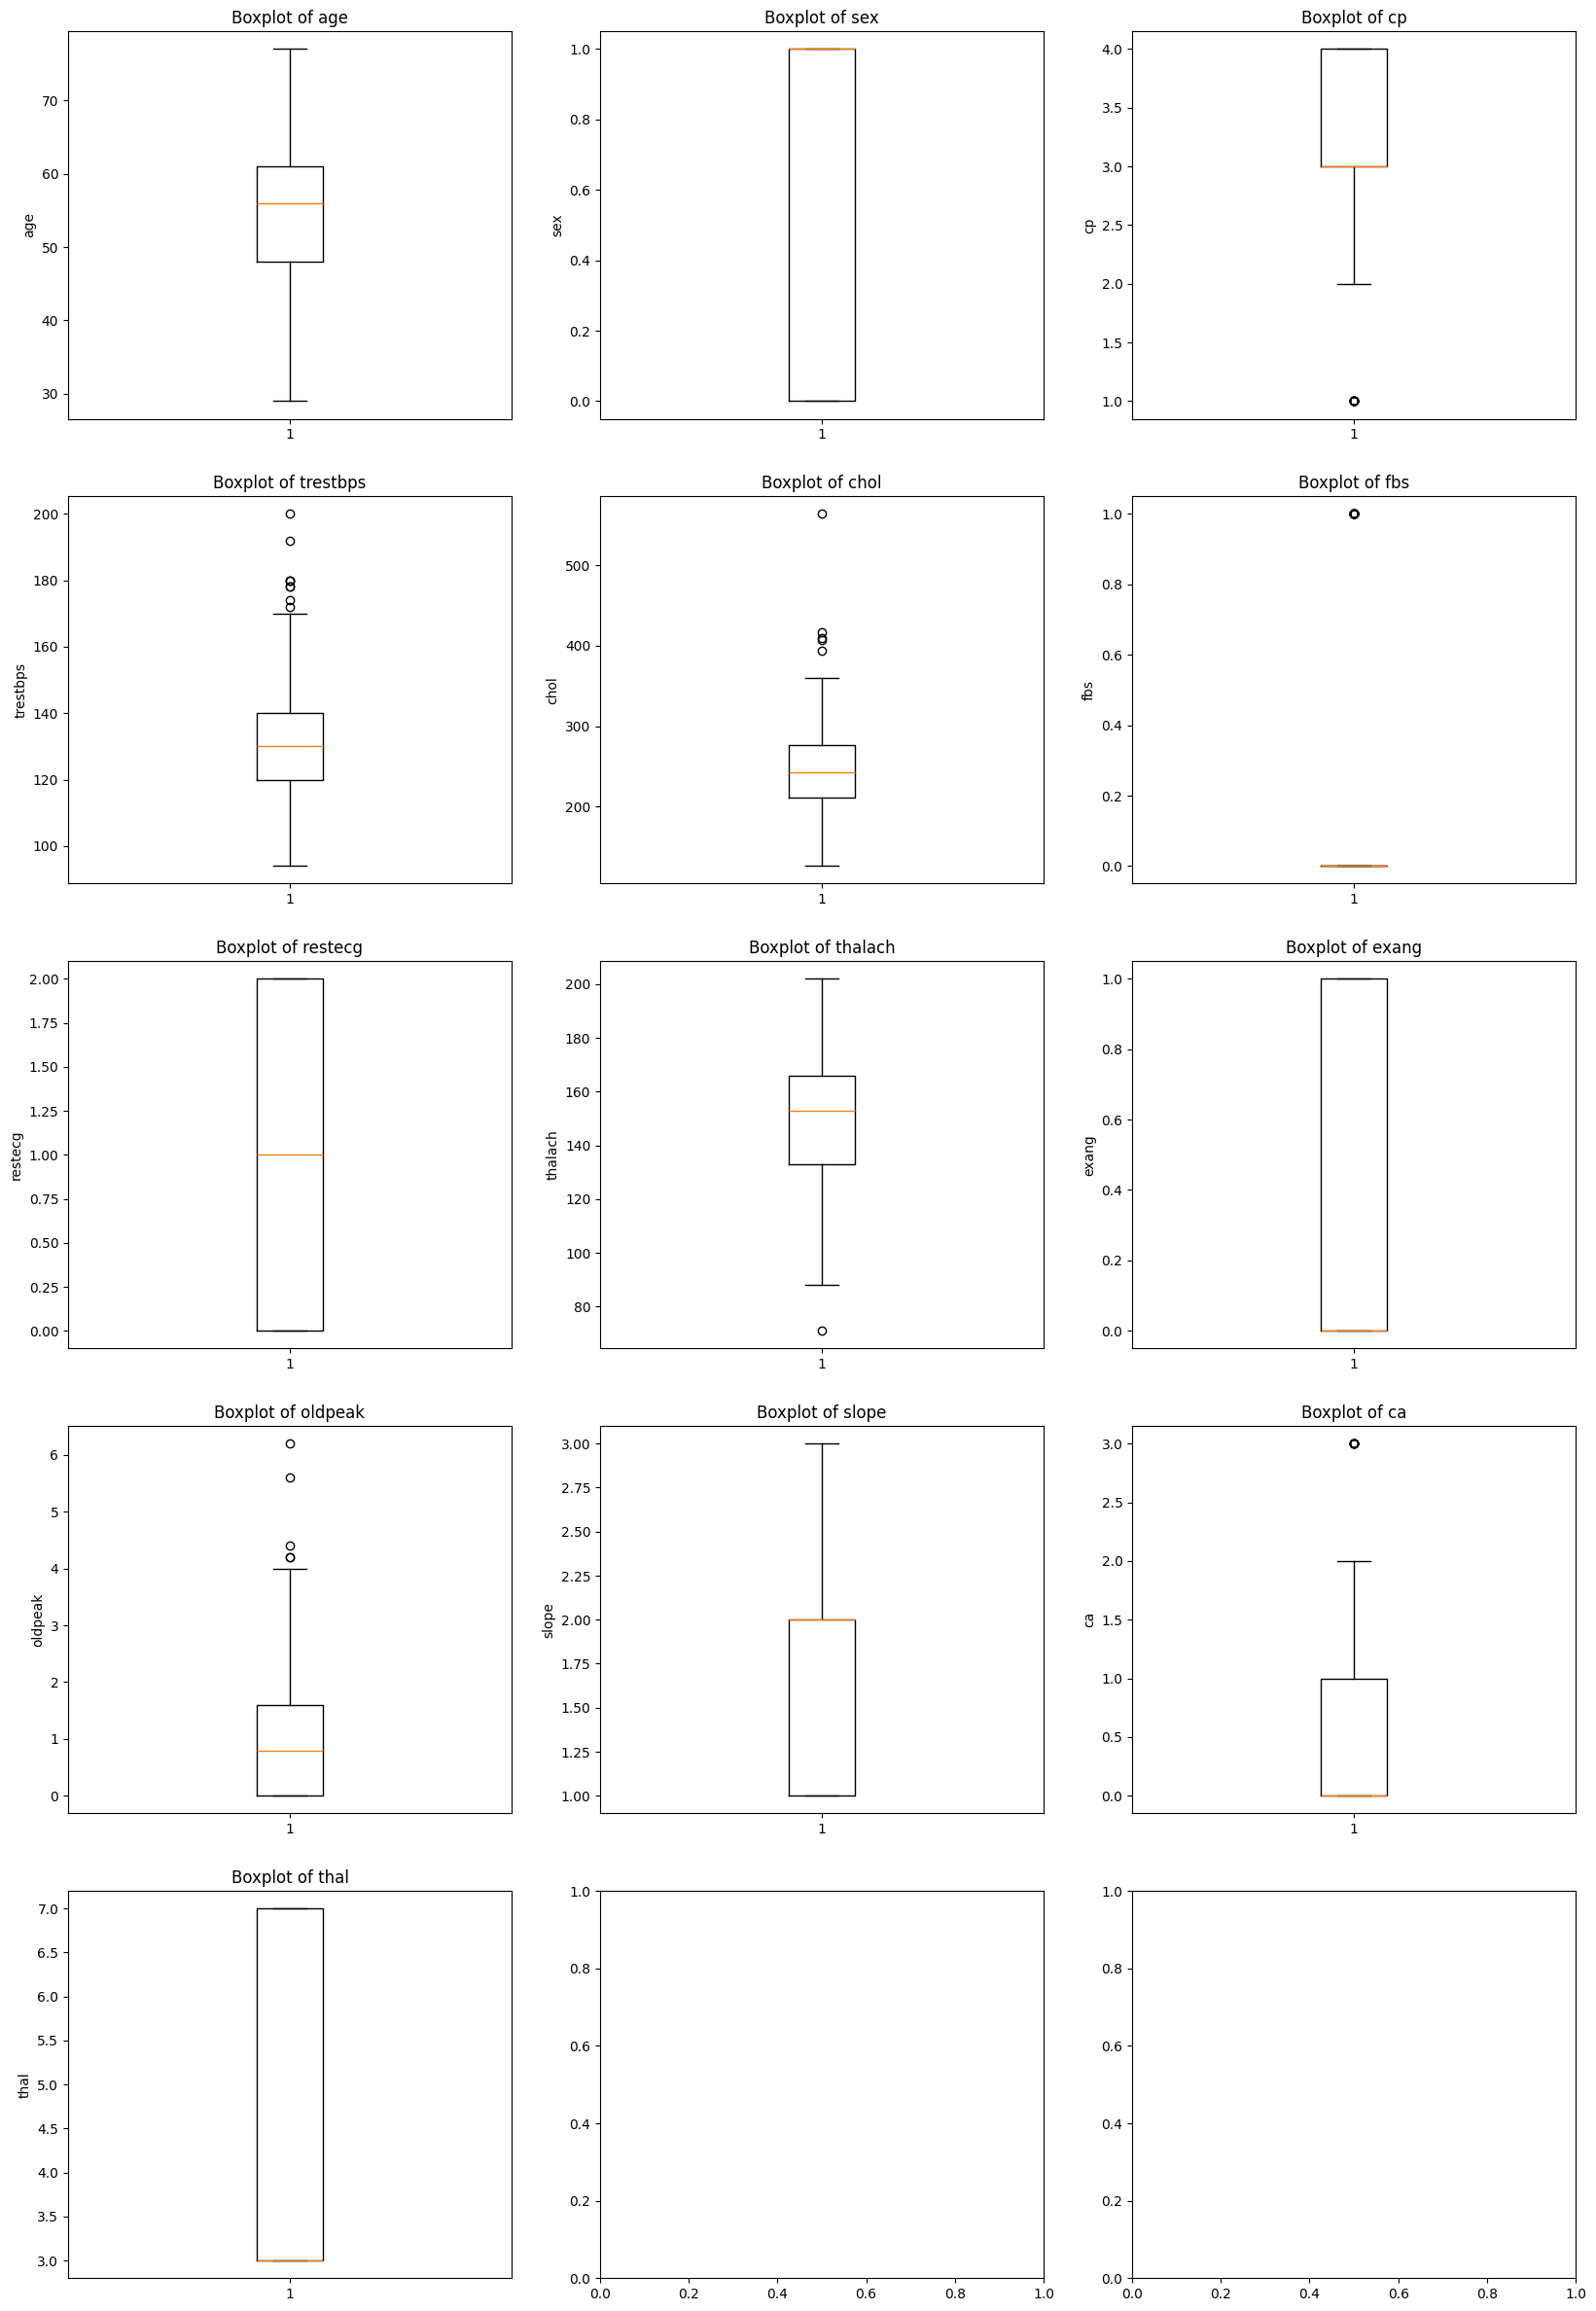

In [ ]:
#  Utilize box plots to visualize the range of features and outliers

# List of features (excluding the target column)
features = data_cleaned.columns[:-1]

# Number of features
num_features = len(features)

ncols = 3
nrows = 5

# Create a figure with subplots for each feature
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
axes = axes.flatten()
for i, feature in enumerate(features):
    axes[i].boxplot(data_cleaned[feature])
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_ylabel(feature)

plt.show()


Presence of outliers and differing ranges in different features indicate that outlier removal and scaling are valuable next steps

### The range highly varied between features, so standardized scaling was used to ensure that each feature contributes equally to the model's performance. Standardization  is particularly useful for models sensitive to the scale of the data, such as Support Vector Machines and Logistic Regression.

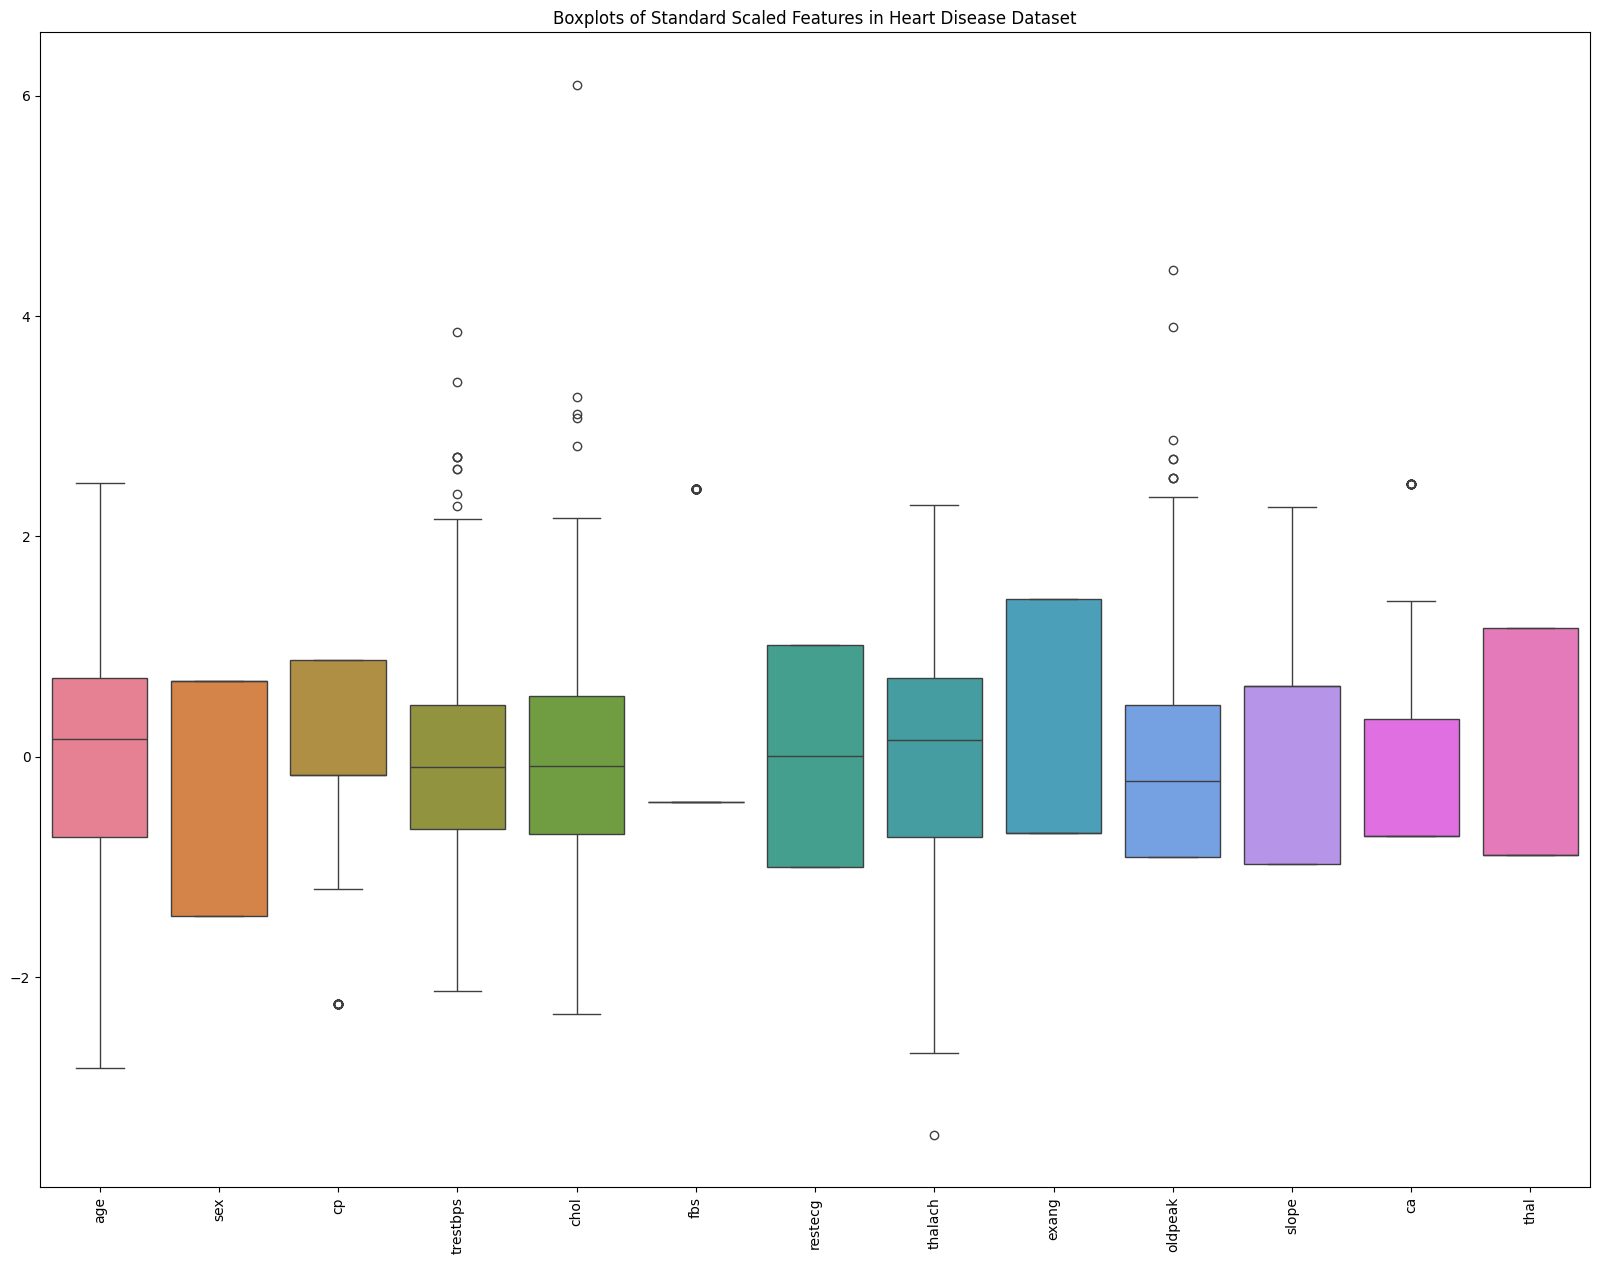

In [ ]:
#Apply standard scaling
standard_scaler = StandardScaler()
data_standard_scaled = standard_scaler.fit_transform(data_cleaned[features])
data_standard_scaled_df = pd.DataFrame(data_standard_scaled, columns=features)
y = data_cleaned.iloc[:, -1] #update the y

# Visualize Standard Scaled Data
plt.figure(figsize=(20, 15))
sns.boxplot(data=data_standard_scaled_df)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Boxplots of Standard Scaled Features in Heart Disease Dataset')
plt.show()

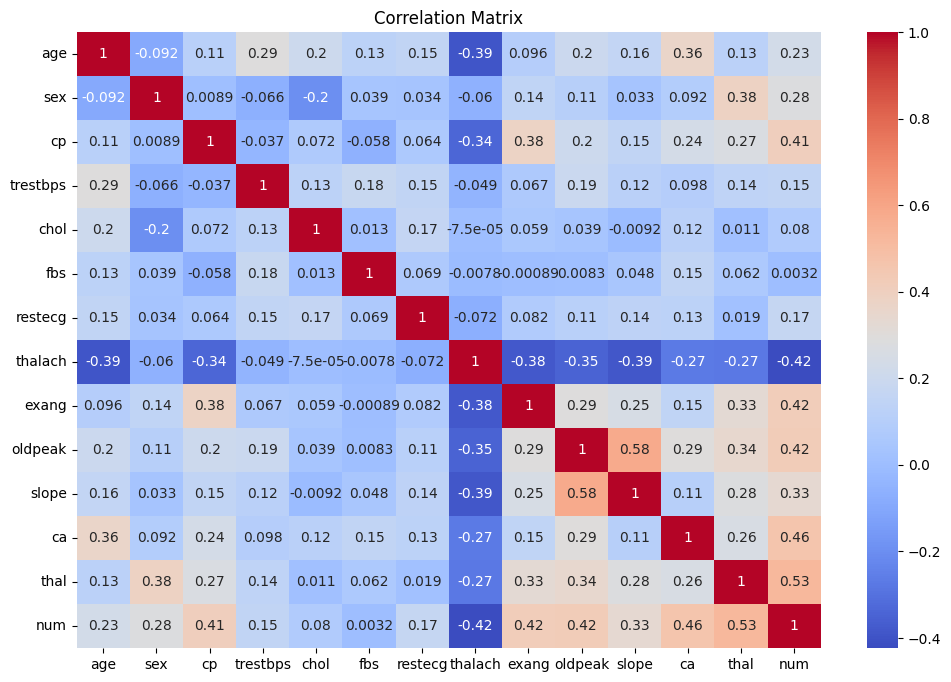

In [ ]:
# create a correlation matrix to help select relevant features
data_standard_scaled_df['num'] = y.values
plt.figure(figsize=(12, 8))
correlation_matrix = data_standard_scaled_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Selected features: "age", "sex", "cp", "thal", "chol", "slope", "ca". Selected based off of high correlated values with “num” from matrix and our knowledge of heart disease.  


# Logistic Regression

### 80/20 split of data set
### Initialize a Logistic Regression model with L2 regularization to prevent overfitting by adding a penalty for larger coefficients in the model
### Train and predict


In [ ]:
# Create Test/Train based on domain knowledge and correlation matrix results
selected_features = ["age", "sex", "cp", "thal", "chol", "slope", "ca"]
# Create Test/Train splits
X = data_standard_scaled_df[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# apply Logistic Regression with L2 regularization
model_lr_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, fit_intercept=True)
model_lr_l2.fit(X_train, y_train)

# predict and evaluate the model
y_pred_lr_l2 = model_lr_l2.predict(X_test)
y_pred_lr_l2_proba = model_lr_l2.predict_proba(X_test)[:, 1]
print("Accuracy with L2 regularization:", accuracy_score(y_test, y_pred_lr_l2))
print(classification_report(y_test,y_pred_lr_l2))


Accuracy with L2 regularization: 0.8833333333333333
              precision    recall  f1-score   support

           0       0.89      0.92      0.90        36
           1       0.87      0.83      0.85        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



# SVM

### Define a parameter grid for hyperparameter tuning different values for the regularization parameter C ([0.1, 1, 10, 100]) and the kernel type ("linear" and "rbf")
### Perform a search over the specified parameter grid with 5-fold (cv=5). This approach ensures that we find the optimal combination of hyperparameters that maximizes the model performance
### Train and predict


In [ ]:
model_svm = svm.SVC(probability=True)
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ["linear","rbf"]}

#utilize GridSearchCV to tune hyperparameters
grid = GridSearchCV(model_svm, param_grid, cv=5, refit = True)
# fitting the model for grid search
grid.fit(X_train, y_train)
svm_pred = grid.predict(X_test)

# Use the best estimator to predict probabilities
best_model = grid.best_estimator_
svm_pred_proba = best_model.predict_proba(X_test)[:, 1]


# Print all the accuracies of the parameters tested
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results[['param_C', 'param_kernel', 'mean_test_score', 'std_test_score']])


print("Accuracy with Best Model from GridSearchCV in SVM:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))
# print best parameter after tuning
print("Best parameters:", grid.best_params_)
# print how our model looks after hyper-parameter tuning
print("Best Model: ", grid.best_estimator_)

   param_C param_kernel  mean_test_score  std_test_score
0      0.1       linear         0.797606        0.027658
1      0.1          rbf         0.789273        0.052645
2      1.0       linear         0.801862        0.033336
3      1.0          rbf         0.801862        0.056521
4     10.0       linear         0.793528        0.039484
5     10.0          rbf         0.763564        0.041426
6    100.0       linear         0.793528        0.039484
7    100.0          rbf         0.755053        0.064328
Accuracy with Best Model from GridSearchCV in SVM: 0.9166666666666666
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        36
           1       0.91      0.88      0.89        24

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60

Best parameters: {'C': 1, 'kernel': 'linear'}
Best Model:  SVC(C=1, kernel='linear', proba

# Try a Booster

### Initialize base SVM model
### Define grid for parameter tuning
### Test number of estimators and learning rates
### Perform a search over the specified parameter grid with 5-fold (cv=5).
### Learning rate of 0.01 is determined as optimal



In [ ]:

# base SVM model
base_svm = svm.SVC(probability=True)

# AdaBoost model with the SVM base estimator
model_ada = AdaBoostClassifier(estimator=base_svm)

# define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}

grid = GridSearchCV(estimator=model_ada, param_grid=param_grid, cv=5)

# fit the model
grid.fit(X_train, y_train)

# make predictions using the best model found by GridSearchCV
y_pred_ada = grid.predict(X_test)

# get the best model
best_model = grid.best_estimator_
print("Best Model:", best_model)

# Print all the accuracies of the parameters tested
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results[['param_learning_rate', 'mean_test_score', 'std_test_score']])


Best Model: AdaBoostClassifier(estimator=SVC(probability=True), learning_rate=0.01,
                   n_estimators=150)
   param_learning_rate  mean_test_score  std_test_score
0                 0.01         0.780762        0.030133
1                 0.01         0.780762        0.030133
2                 0.01         0.785018        0.032180
3                 0.10         0.780585        0.050935
4                 0.10         0.784840        0.048592
5                 0.10         0.776418        0.048662
6                 1.00         0.738564        0.053857
7                 1.00         0.733954        0.038419
8                 1.00         0.755408        0.019784


In [ ]:
#Best adaboost based on gridsearch
base_svm = svm.SVC(probability=True)
model_ada = AdaBoostClassifier(estimator=svm.SVC(probability=True), learning_rate=0.01, n_estimators=100)

model_ada.fit(X_train, y_train)

y_pred_ada =model_ada.predict(X_test)
y_pred_ada_proba = model_ada.predict_proba(X_test)[:, 1]

# print accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))

Accuracy Score: 0.9333333333333333
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.92      0.92      0.92        24

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60



# Cross-Validation

### By testing multiple values of k in K-Fold cross-validation, we gain insights into the stability and robustness of each model.

In [ ]:
# List of k values to test
k_values = [3, 5, 7, 10]

# Models to evaluate
models = {
    "Logistic Regression": model_lr_l2,
    "SVM": model_svm_rbf,
    "AdaBoost": model_ada
}

# Function to perform cross-validation and print results
def evaluate_models(models, X_train, y_train, k_values):
    for k in k_values:
        print(f"\nK={k} folds:")
        kf = KFold(n_splits=k, shuffle=True, random_state=128)
        for model_name, model in models.items():
            scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
            print(f"Mean {model_name} CV Accuracy: {scores.mean():.4f}")

# Call the function to evaluate models
evaluate_models(models, X_train, y_train, k_values)


K=3 folds:
Mean Logistic Regression CV Accuracy: 0.7764
Mean SVM CV Accuracy: 0.7806
Mean AdaBoost CV Accuracy: 0.7764

K=5 folds:
Mean Logistic Regression CV Accuracy: 0.7766
Mean SVM CV Accuracy: 0.7850
Mean AdaBoost CV Accuracy: 0.7976

K=7 folds:
Mean Logistic Regression CV Accuracy: 0.7804
Mean SVM CV Accuracy: 0.7888
Mean AdaBoost CV Accuracy: 0.7760

K=10 folds:
Mean Logistic Regression CV Accuracy: 0.7851
Mean SVM CV Accuracy: 0.7933
Mean AdaBoost CV Accuracy: 0.8022


### The SVM model generally performs well across different k values, showing consistent improvement with increasing k.

### The AdaBoost model shows the highest mean accuracy for k=10 folds, indicating its potential advantage with more training splits.

### Logistic Regression maintains relatively stable performance across different k values, with a slight improvement as k increases.



# ROC Analysis

### Define function for calculating TPR, PPV, FPR, accuracy, and plotting the ROC curve and getting AUC.

### Pass each model through the ROC analysis function


Accuracy: 0.8833
True Positive Rate (Sensitivity): 0.8333
Positive Predictive Value (Precision): 0.8696
False Positive Rate: 0.0833


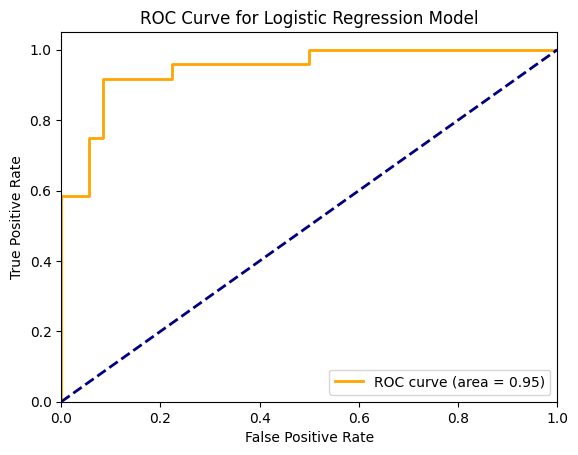

Accuracy: 0.9167
True Positive Rate (Sensitivity): 0.8750
Positive Predictive Value (Precision): 0.9130
False Positive Rate: 0.0556


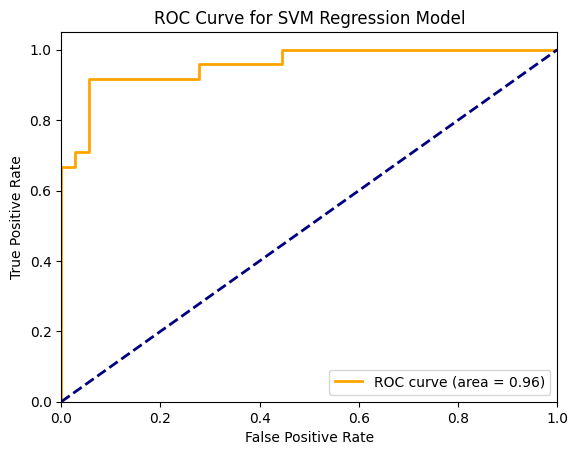

Accuracy: 0.9333
True Positive Rate (Sensitivity): 0.9167
Positive Predictive Value (Precision): 0.9167
False Positive Rate: 0.0556


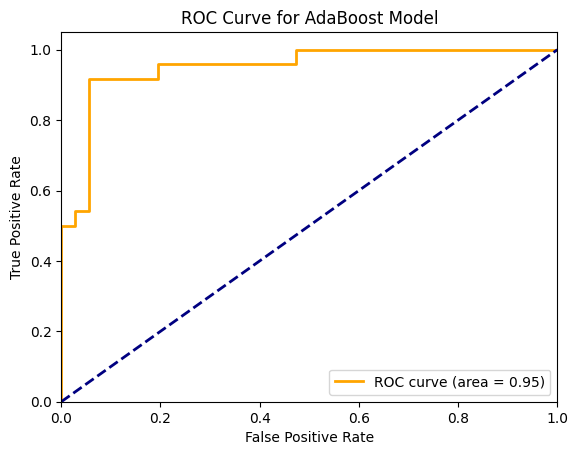

(np.float64(0.9333333333333333),
 np.float64(0.9166666666666666),
 np.float64(0.9166666666666666),
 np.float64(0.05555555555555555))

In [ ]:
# function for roc metrics and plot
def calculate_metrics_and_plot_roc(y_test, y_pred, y_pred_proba, name):
    # calculate metrics
    tp = np.sum((y_test == 1) & (y_pred == 1))
    tn = np.sum((y_test == 0) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)  # True Positive Rate
    ppv = tp / (tp + fp)  # Positive Predictive Value
    fpr = fp / (fp + tn)  # False Positive Rate

    # print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'True Positive Rate (Sensitivity): {tpr:.4f}')
    print(f'Positive Predictive Value (Precision): {ppv:.4f}')
    print(f'False Positive Rate: {fpr:.4f}')

    # plot ROC curve
    fpr_curve, tpr_curve, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr_curve, tpr_curve)

    plt.figure()
    plt.plot(fpr_curve, tpr_curve, lw=2, color="orange", label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, tpr, ppv, fpr

#call function for all models
calculate_metrics_and_plot_roc(y_test,y_pred_lr_l2, y_pred_lr_l2_proba, "Logistic Regression Model")
calculate_metrics_and_plot_roc(y_test,svm_pred, svm_pred_proba , "SVM Regression Model")
calculate_metrics_and_plot_roc(y_test,y_pred_ada, y_pred_ada_proba, "AdaBoost Model")

# Interpretation

### All three models demonstrate strong performance in predicting heart disease, with high accuracy, sensitivity, precision, and low false positive rates. The AUC scores indicate excellent discrimination ability for each model, with values close to 1.
### Accuracy: AdaBoost has the highest accuracy at 93.33%
### Sensitivity: AdaBoost also shows the highest sensitivity at 91.67%
### Precision: AdaBoost and SVM have similarly high precision at 91.67% and 91.30%
### False Positive Rate: Both SVM and AdaBoost have a lowest false positive rate of 5.56%
### AUC: SVM leads with an AUC of 0.96, indicating slightly better discrimination ability than Logistic Regression and AdaBoost, both of which have an AUC of 0.95.
### Overall, while all models perform well, AdaBoost appears to have a slight edge in terms of overall accuracy and sensitivity, making it a strong candidate for predicting heart disease in this dataset.
